# Lab Sheet 8 (COM3502-4502-6502 Speech Processing)

This lab sheet is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/Lab-Sheet-8.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

In [20]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling ((un-)comment if you want)
import numpy as np               # math

# imports we need in addition for this lab sheet
from IPython import display as ipd
import scipy.signal as sig
import soundfile as sf
from scipy.io.wavfile import read as wavread

<br>
<a id='task_1'></a>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 1:**
    
<ul>
<li> 
    Load two WAVE files containing speech and noise, e.g. <code>speech_8kHz_murder.wav</code> and <code>noise_8kHz.wav</code> from the Internet address <code>https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/</code> and load them into two variables <code>s</code> and <code>n</code>.
</li> 
  <li>   
    Create a microphone signal $y[k] = s[k]+n[k]$ as shown in the schematic below. Note that the vectors should be cut the same length if needed. Also note that we will do the filtering in the following.

<img src="NRSingleChannelBasic-web.png" align="center"/>
    </li> 
</ul>
</div>

In [21]:
# your code here
# ....

s_file_name = 'speech_8kHz_murder.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{s_file_name} -o {s_file_name} 
    
n_file_name = 'noise_8kHz.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{n_file_name} -o {n_file_name}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  328k  100  328k    0     0  2884k      0 --:--:-- --:--:-- --:--:-- 2884k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57808  100 57808    0     0  1085k      0 --:--:-- --:--:-- --:--:-- 1106k


In [22]:
# load speech wave into variable
s, fs = sf.read(s_file_name)

print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

n, fs = sf.read(n_file_name)

print('File "' + n_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

File "speech_8kHz_murder.wav" loaded. Its sampling rate is 8000 Hz.
File "noise_8kHz.wav" loaded. Its sampling rate is 8000 Hz.


In [23]:
# listen to the sound file (if you want)
ipd.Audio(s, rate=fs)

In [24]:
# listen to the noise file (if you want)
ipd.Audio(n, rate=fs)

In [25]:
y = n + s[:len(n)]

# listen to the modelled microphone signal (if you want)
ipd.Audio(y, rate=fs)

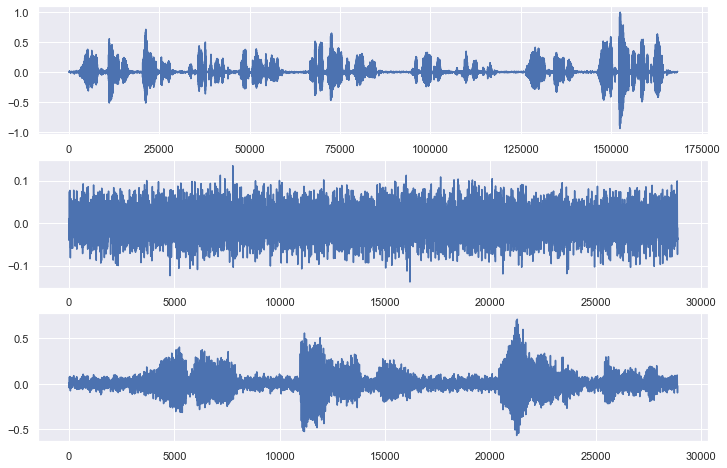

In [26]:
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(s)
plt.subplot(3,1,2)
plt.plot(n)
plt.subplot(3,1,3)
plt.plot(y)

# Overlap-add Processing

When processing long duration signals it is common practise to do so by splitting the long signal into a series of shorter windows or chunks. This is for two reasons. First, dealing with the full signal 'in one go' is impractical due to constraints in computational memory. Second, to attain useful inference from operations such as the discrete Fourier Transform, it is assumed that the signal under scrutiny is time invariant (i.e its statistical properties do not vary with time), this is only typically true when analysing signals over short time frames. 

A simple algorithm to perform such chunk-wise processing is the Overlap-Add method.

Overlap-Add processing can effectively be broken down into 3 stages:
<ul>
<li> 
    <strong>Fragmentation</strong> - Extract windows of size $L$ by iteratively applying a windowing function, such as Hanning, to each chunk with each window overlapping by $M$ number of samples. $M$ is typically $L/2$ in speech processing, i.e the overlapping fraction is that of the window length halved.
</li> 
<li>
    <strong>Processing</strong> - Each windowed chunk is processed independently, by convolving with a FIR filter for example.
</li>
<li>
    <strong>Reconstruction</strong> - The processed windows are 'added' back together sequentially to retain each window's relative position in the original signal.
</li>
</ul>
    
The process is described mathematically below where a long signal, $X[n]$, is to be convolved with a finite impulse response filter, $Y[n]$.   
 
 
$$X_{k}\left [ n \right ] = \left\{\begin{matrix}
X[n+kL] & n=1,2,...,L\\ 
0 & otherwise
\end{matrix}\right.$$
  
$$X[n]=\sum_{k}X_{k}[n-kL]$$  
  
\begin{align*}
Y[n]=&X[n]\ast H[n]
\\=&\left ( \sum_{k}X_{k}[n-kL] \right )\ast H[n]
\\=&\sum_{k}X_{k}[n-kL]\ast H[n]
\\=&\sum_{k}Y_{k}[n-kL]
\end{align*}
  
 
Since speech signals are time variant in nature, it is beneficial to utilise the Overlap-Add algorithm during the processing of them. This is further justified by the assumption that, heuristically speaking, fragmented speech present in each window roughly represents a phoneme, where the signal is assumed to be time invariant.



<br>
<a id='task_1'></a>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 2: Perform windowing on your modelled microphone signal.**
    
<ul>
<li> Extract a short temporal range from your modelled microphone signal; around 1 second of audio.
</li>     
<li>
    Finish the below function to iterate through said range applying a windowing function from the numpy library to each iteration. 
</li>
<li> 
    Have the function accept the following parameters: your shortened microphone signal as a positional argument; type of windowing function to use from numpy library (hamming, blackman, hanning...), phoneme duration, and sampling frequency as a keyword argument to the function. 
</li> 
<li>
       Have the function return a list or np.array() of all extracted windows, with each window padded with zeros so that all windows are of the same length as the original input.
</li>
<li>
       Test your function with the 'Blackman' filter.
</li>
</ul>
</div>

In [27]:
def get_windows(sample, phoneme_duration = 0.03, fs = 8000, window_choice = 'Blackman'):
    """
    Extracts windows from a signal for a given phoneme duration using a windowing
    function from the numpy library.
    
    Input:
        sample: list or np.array
            input signal to window
        phoneme_duration: float
            desired window length in seconds
        fs: int
            sampling frequency of signal
        window_choice: str
            windowing function to use, one of: Blackman, Hamming, Hanning
    Output:
        list of np.arrays
    
    Example:
       list_of_windows = get_windows(sample, phoneme_duration = 0.025, sr=8000, window_choice = 'hanning')
    """
    
    
    return windows

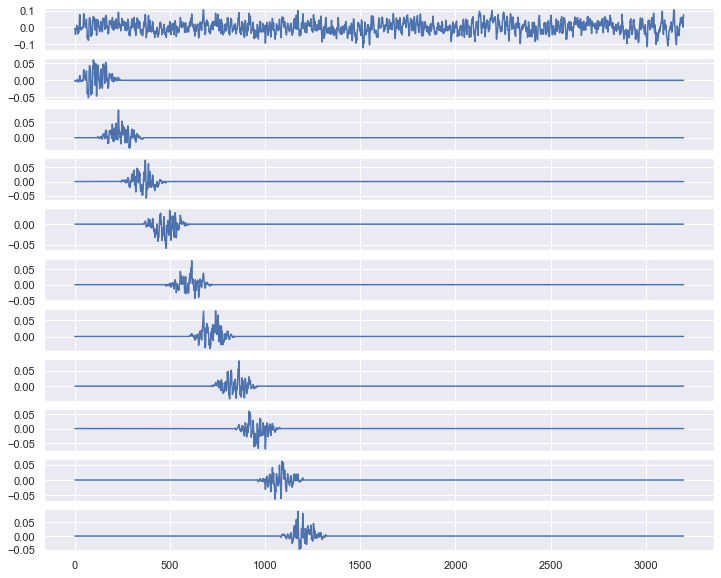

In [28]:
%matplotlib inline
## answer
def get_windows(sample, phoneme_duration = 0.03, fs = 8000, window_choice = 'Blackman'):
    """
    Extracts windows from a signal for a given phoneme duration using a windowing
    function from the numpy library.
    
    Input:
        sample: list or np.array
            input signal to window
        phoneme_duration: float
            desired window length in seconds
        fs: int
            sampling frequency of signal
        window_choice: str
            windowing function to use, one of: Blackman, Hamming, Hanning
    Output:
        list of np.arrays
    
    Example:
       list_of_windows = get_windows(sample, phoneme_duration = 0.025, sr=8000, window_choice = 'hanning')
    """
    L_2 = phoneme_duration/2*fs
    window_centres = np.arange(L_2, len(sample), L_2)
    lowers = window_centres-L_2
    uppers = window_centres+L_2
    windowed = []
    for c in window_centres:
        fragment = sample[int(c-L_2):int(c+L_2)]
        window_funcs = {'Hamming': np.hamming(len(fragment)), 'Blackman': np.blackman(len(fragment)),
              'Hanning': np.hanning(len(fragment))}
        pad_left = int(c-L_2)
        pad_right = len(sample) - int(c+L_2)
        if pad_right < 0:
            pad_right = 0
        windowed.append(np.pad(fragment*window_funcs[window_choice],
               (pad_left, pad_right), 'constant'))
    
    return windowed

T = 0.4
sample = y[:int(fs*T)]

windowed = get_windows(sample, window_choice = 'Hamming')
plt.figure(figsize=(12,10))
plt.subplot(11,1,1)
plt.plot(sample)
for i,w in enumerate(windowed[:10]):
    plt.subplot(11,1,i+2)
    plt.plot(w)

## Princeton-Bradley Criteria

A desired property of the windowing process used in an Overlap-Add algorithm is that the windowing iteslf should not alter the original signal after signal reconstruction. This is known as the Princeton-Bradley Criteria.


<br>
<a id='task_1'></a>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 3: Try your windowing function with the phoneme_duartion as 0.03 seconds and window_choice = 'Blackman'. Do you think the output from this configuration satisfies the Princeton-Bradley Criteria?**
    
**Hint**: You can test this by simply summing the output of your window function and subtracting this from your original shortened microphone signal.
</div>

Text(0.5, 0, 'Time [samples]')

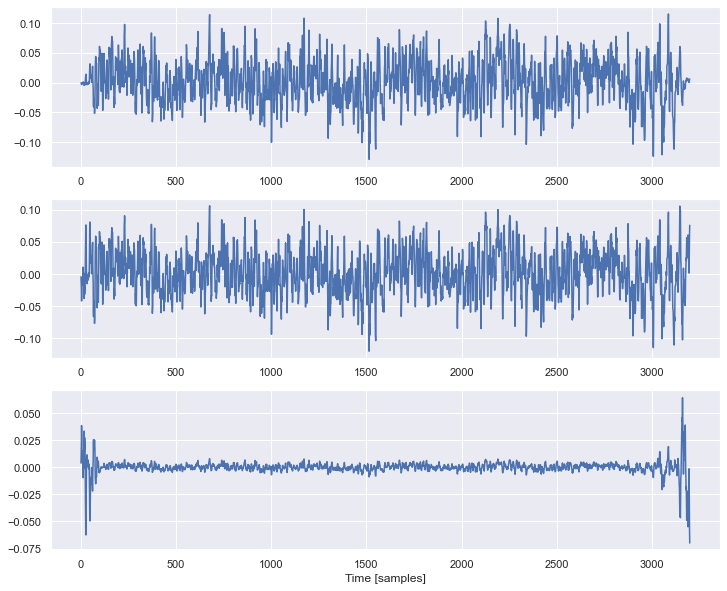

In [29]:
reconstructed = sum([w for w in windowed])
plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
plt.plot(reconstructed)
plt.subplot(3,1,2)
plt.plot(sample)
plt.subplot(3,1,3)
plt.plot(reconstructed-sample)
plt.xlabel('Time [samples]')

<span style="color:red">Need to add maths for why this doesn't work and why it works with Hanning.</span>.


<br>
<a id='task_1'></a>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 4: Retry with Hamming windowing choice. Does this satisfy the Princeton-Bradley Criteria?**
    
</div>

Text(0.5, 0, 'Time [samples]')

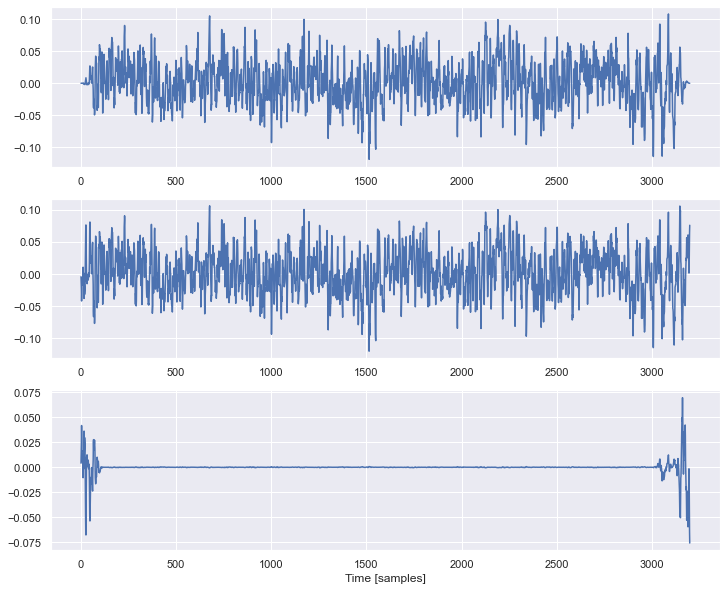

In [30]:
windowed = get_windows(sample, window_choice = 'Hanning')
reconstructed = sum([w for w in windowed])
plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
plt.plot(reconstructed)
plt.subplot(3,1,2)
plt.plot(sample)
plt.subplot(3,1,3)
plt.plot(reconstructed-sample)
plt.xlabel('Time [samples]')

## Overlap-Add Function
<br>
<a id='task_1'></a>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 5: Create a function from scratch which implements the Overlap-Add to perform Finite Impulse Response filtering.**
    
<ul>
<li> Create an instance of an FIR filter from the scipy.signal.firwin() and plot the impulse response of the filter.
</li>     
<li> 
   Create a function which: performs windowing (zero padding here is no longer necessary), transforms both the filter and windows to the frequency domain via np.fft.rfft(), and reconstructs the filtered signal.
</li> 
</ul>
</div>

In [274]:
def overlap_add_filtering(signal, filt, L_I):
    """
    Overlap-Add filtering.
    
    Input:
        signal: np.array or list
            input signal to process
        filt: np.array
            impulse response of FIR filter
        L_I: int
            length of FIR filter
    Output:
        filtered signal
    
    Example:
       overlap_add_filtering(signal, testfilt, 1000)
    """
    bits_to_shift_by = (L_I-1).bit_length() # number of bits necessary to represent in binary
    L_F = 2<<bits_to_shift_by # length of fourier transform window
    L_W = L_F - L_I + 1 # length of signal to be filtered in single window overlap iteration
    
    filt_F = np.fft.rfft(filt, n=L_F) # filter in frequency domain
    
    
    #YOUR WORK HERE
    
    
    
        
    return signal_f[:len(signal)] #truncate to length of original signal

<class 'numpy.ndarray'>


Text(0.5, 0, 'Time [samples]')

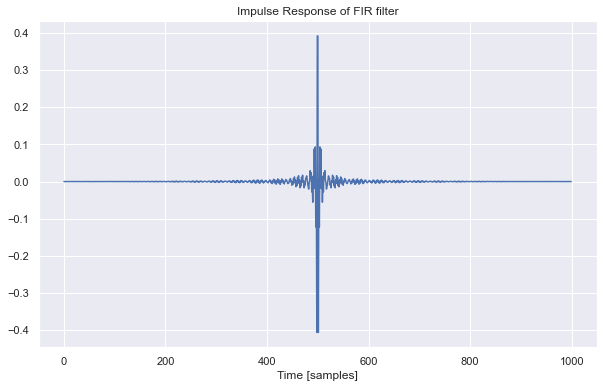

In [12]:
####answer 
def overlap_add_filtering(signal, filt, L_I):
    """
    Overlap-Add filtering.
    
    Input:
        signal: np.array or list
            input signal to process
        filt: np.array
            impulse response of FIR filter
        L_I: int
            length of FIR filter
    Output:
        filtered signal
    
    Example:
       overlap_add_filtering(signal, testfilt, 1000)
    """
    bits_to_shift_by = (L_I-1).bit_length() # number of bits necessary to represent in binary
    L_F = 2<<bits_to_shift_by # length of fourier transform window
    L_W = L_F - L_I + 1 # length of signal to be filtered in single window overlap iteration
    
    filt_F = np.fft.rfft(filt, n=L_F) # filter in frequency domain
    
    windows = [w for w in range(0, len(signal), L_W)]
    
    windows_f = []
    for w in windows:
        signal_w = signal[w:w+L_W] # windowed signal
        signal_w_F = np.fft.rfft(signal_w, n=L_F) #windowed signal in frequency domain
        windows_f.append(np.fft.irfft(signal_w_F*filt_F)) #filtered windowed signal in time domain 
    
    signal_f = np.zeros(len(signal) + L_F)
    for i,n in enumerate(windows):
        signal_f[n:n+L_F] += windows_f[i]
        
    return signal_f[:len(signal)] #truncate to length of original signal


#create instance of FIR filter and plot impulse response

L_I = 1000 # impulse response (number of samples)

# create filter
testfilt = sig.firwin(L_I, [1000, 3900], nyq=fs/2, pass_zero=False) #num_taps (filter order + 1), cutoff frequency 
print(type(testfilt))
plt.figure(figsize = (10,6))
plt.plot(testfilt)
plt.title('Impulse Response of FIR filter')
plt.xlabel('Time [samples]')

## Computational Effeciency of Overlap-Add

<br>
<a id='task_1'></a>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 5: Compare the speed of your Overlap-Add filtering function with using scipy's function.**
    
<ul>
<li> 
   Use %timeit to record the time taken for scipy.signal.lfilter() to operate on your filter.
</li> 
<li>
   Do the same with your overlap_add_filtering_function, compare speed.
</li>
</ul>
</div>

In [13]:
#filter with sig.lfilter and record time
%timeit sig.lfilter(testfilt, [1, ], y)
scipy_filtered = sig.lfilter(testfilt, [1, ], y)
%timeit overlap_add_filtering(y, testfilt, L_I)
oa_filtered = overlap_add_filtering(y, testfilt, L_I)

2.99 ms ± 37.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
938 µs ± 3.74 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Text(0.5, 0, 'Time [Samples]')

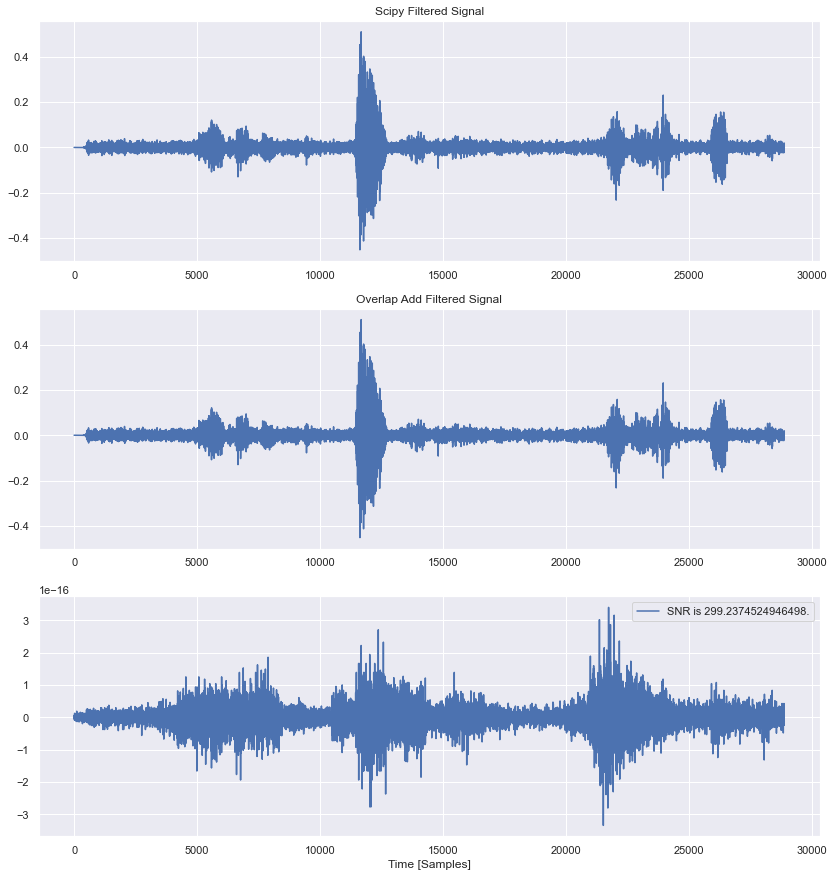

In [14]:
plt.figure(figsize =(14,15))
plt.subplot(3,1,1)
plt.plot(scipy_filtered)
plt.title('Scipy Filtered Signal')
plt.subplot(3,1,2)
plt.plot(oa_filtered)
plt.title('Overlap Add Filtered Signal')
plt.subplot(3,1,3)
sn = 'SNR is {}.'.format(10*np.log10(np.sum(oa_filtered**2)/np.sum((oa_filtered-scipy_filtered)**2)))
plt.plot(oa_filtered-scipy_filtered, label = sn)
plt.legend()
plt.xlabel('Time [Samples]')

 # Real Time Spectrogram

In [ ]:
"""
Need more time to finish this section to have it more polished/robust and have the option to perform
streamed spectrogram processing rather than using a prerecorded file
"""

In [15]:
try:
    import sounddevice as sd  # https://python-sounddevice.readthedocs.io
except ModuleNotFoundError:
    !pip3 install sounddevice #requires pyaudio to be installed, for linux:https://medium.com/@niveditha.itengineer/learn-how-to-setup-portaudio-and-pyaudio-in-ubuntu-to-play-with-speech-recognition-8d2fff660e94
    import sounddevice as sd 

In [37]:
from scipy.io.wavfile import write

fs = 44100  # Sample rate
seconds = 15  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()  # Wait until recording is finished
write('output.wav', fs, myrecording)  # Save as WAV file 



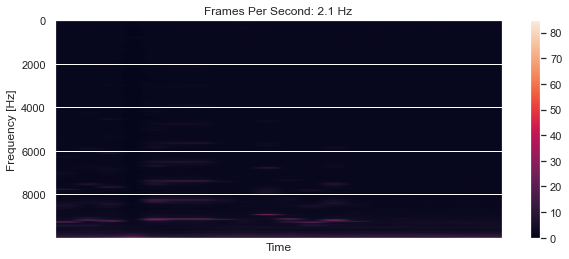

In [44]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import time
import collections
import soundfile as sf
%matplotlib inline

def block_specgram(filepath, sr=44100, n_ch=2, n_fft=32768,
                  n_plot_tf=80, f_max_idx=10000, window_choice = 'hamming'):
    """
    Block processes a spectrogram for a given sound file producing a dynamic plot.
    
    Input:
        filepath: str
            location of wav file to be processed
        sr: int
            sample rate of wav file
        n_ch: int
            number of channels used to record wav file
        n_fft: int
            length of fft (number of frequency bins), should be of base 2
        n_plot_tf: int
            number of time bins
        f_max_idx: int
            maximum frequency - 1 < f_max_idx < n_freqs
        window_choice: str of: 'blackman'; 'hamming'; 'hanning' 
            window function 
    Output:
        Dynamic spectrogram
    
    Example:
        block_specgram('speech processing/output.wav', sr=44100, window_choice = 'hanning')
    """
    
    windows = {'hamming': np.hamming(n_fft), 'blackman': np.blackman(n_fft),
              'hanning': np.hanning(n_fft)}
    hop_length = int(n_fft / 4 * 3) # 0 <= hop_length < n_fft
    overlap = n_fft - hop_length
    n_freqs = n_fft//2 + 1
    window = windows[window_choice]
    
    fps = 1
    vmax, vmin = 1, 0
    amp = np.zeros((n_plot_tf, f_max_idx))
    pretime = time.time()
    
    for index, block in enumerate(sf.blocks(filepath, blocksize=n_fft, overlap=overlap)):
        if block.shape[0] != n_fft:
            continue

        x = np.mean(block, axis=1) #monaural
        amp[-1] = np.sqrt(np.abs(np.fft.rfft(window*x)))[0:f_max_idx] #real fft
        
        if vmax < np.max(amp[-1]): #for normalisation
            vmax = np.max(amp[-1])
        
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10,4))
        image = ax.imshow(amp.T, aspect="auto")
        ax.set_xlabel(f"Time")
        ax.set_ylabel(f"Frequency [Hz]")
        fig.colorbar(image)
        image.set_clim(vmin, vmax)
        image.set_data(amp.T[::-1])

        plt.xticks([]) #no time ticks

        plt.title(f"Frames Per Second: {fps:0.1f} Hz")
        plt.pause(0.001)

        amp[0:-1] = amp[1::]

        curtime = time.time()
        time_diff = curtime - pretime
        fps = 1.0/(time_diff + 1e-16)
        #print(f"{index}:\t{time_diff:0.3f} sec")
        pretime = curtime
    
    plt.close()
    
block_specgram('output.wav', n_plot_tf=20)

In [155]:
seconds = 0.05
fs = 44100
a = []
t2 = time.time()
for i in range(int(4/seconds)):
    t0 = time.time()
    block = sd.rec(int(seconds * fs), samplerate=fs, channels=1,blocking=True)
    print((time.time()-t0)/seconds)
    a.append(block)

print('')
print(time.time()-t2)
write('output.wav', fs, np.concatenate(a))


3.7581491470336914
2.2069597244262695
2.2280406951904297
1.9041109085083008
1.6113948822021484
2.1451854705810547
2.2274398803710938
2.246270179748535
2.2328662872314453
2.2264719009399414
2.1391773223876953
2.1831369400024414
1.7337703704833984
2.229127883911133
2.245206832885742
2.2327327728271484
2.2435474395751953
2.103281021118164
1.9404315948486328
2.279210090637207
1.9339418411254883
2.154831886291504
1.790318489074707
2.027153968811035
2.2193384170532227
2.1945858001708984
1.6114425659179688
1.9446325302124023
2.2389745712280273
2.1075916290283203
2.2287368774414062
2.119717597961426
1.522226333618164
2.133359909057617
2.207827568054199
2.249722480773926
1.8189001083374023
2.23477840423584
2.090907096862793
1.507124900817871
2.1228837966918945
2.227659225463867
1.6064691543579102
1.4946985244750977
1.6258811950683594
2.3380041122436523
2.2897815704345703
1.3907384872436523
1.5128135681152344
1.7100143432617188
1.6884040832519531
1.6021537780761719
1.6865777969360352
1.495003700

In [147]:
from scipy.io.wavfile import write

fs = 8000  # Sample rate
seconds = 0.05 # Duration of each recording block
desired_duration = 5 #in seconds
a = []
for i in range(int(desired_duration/seconds)): 
    block = sd.rec(int(seconds * fs), samplerate=fs, channels=1,blocking=True)
    #sd.wait()  # Wait until recording is finished
    #perform streamed block processing on block
    a.append(block)

write('output.wav', fs, np.concatenate(a))  # Save as WAV file 

In [146]:
sd.rec?

## Adding Reverberation by convolving with Room Impulse Responses (RIRs)

Room Impulse Responses (RIRs) charaterise rooms acoustically. They can be generated from the room geometry using the [Room Impulse Response Generator](https://www.audiolabs-erlangen.de/fau/professor/habets/software/rir-generator) which has to be installed using the `!pip install rir_generator` once and can then be imported. 

<br>
<a id='task_1'></a>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 1:**
    
<ul>
<li> 
    Load two WAVE files containing speech and noise, e.g. <code>speech_8kHz_murder.wav</code> and <code>noise_8kHz.wav</code> from the Internet address <code>https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/</code> and load them into two variables <code>s</code> and <code>n</code>.
</li> 
<li> 
    a
</li> 
</ul>
</div>

In [7]:
# uncomment the following line if you need to install
!pip install rir_generator 
import rir_generator as rir

  Using cached rir-generator-0.1.0.tar.gz (8.6 kB)
  Running setup.py clean for rir-generator
Failed to build rir-generator
    Running setup.py install for rir-generator: started
    Running setup.py install for rir-generator: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\stefan\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\stefan\\AppData\\Local\\Temp\\pip-install-kiltfjr2\\rir-generator_21a94f20808649d994566fc036ad6246\\setup.py'"'"'; __file__='"'"'C:\\Users\\stefan\\AppData\\Local\\Temp\\pip-install-kiltfjr2\\rir-generator_21a94f20808649d994566fc036ad6246\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\stefan\AppData\Local\Temp\pip-wheel-vcxb2qv5'
       cwd: C:\Users\stefan\AppData\Local\Temp\pip-install-kiltfjr2\rir-generator_21a94f20808649d994566fc036ad6246\
  Complete output (25 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\

ModuleNotFoundError: No module named 'rir_generator'

## Copyright

This notebook is licensed to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). Any further use (beyond use for the lecture) is only permitted if agreed with the [module lead](mailto:s.goetze@sheffield.ac.uk). 